# 01 - ComCam x Milliquas
**Author:** Olivia Lynn & Neven Caplar 
**Last Run:** May 13, 2025

*Part of the [AGN Variability project from March 2025](https://docs.google.com/document/d/1yb43z7vrG5-FIL6lNZjVkIx41jKSCl698d51RQhXRqg/edit?tab=t.0)*

## Set up
Imports and dask

In [2]:
import lsdb
print(lsdb.__version__)
import hats
print(hats.__version__)
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from nested_pandas import NestedDtype

0.5.3.dev6+gfc62489
0.5.3.dev2+g9f35663


In [3]:
client = Client(n_workers=4, memory_limit="auto")
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-6ihywjoz', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-p_otcolu', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-jysjm40v', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-uoq_wdnb', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-4v2dshlz', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-__nvvwhs', purging
INFO:distributed.diskutils:Found stale loc

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 120,Total memory: 511.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:21611,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:8819,Total threads: 30
Dashboard: http://127.0.0.1:30553/status,Memory: 127.98 GiB
Nanny: tcp://127.0.0.1:16769,


INFO:distributed.scheduler:Remove client Client-b5e057d2-3074-11f0-af59-303ea7003418
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50858; closing.
INFO:distributed.scheduler:Remove client Client-b5e057d2-3074-11f0-af59-303ea7003418
INFO:distributed.scheduler:Close client connection: Client-b5e057d2-3074-11f0-af59-303ea7003418
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1747193876.884767') (0, 1, 2, 3)
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50852; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50830; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50848; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:8819 name: 0 (stimulus_id='handle-worker-cleanup-1747193876.8915372')
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:13433 name: 1 (stimulus_id='handle-worker-cleanup-1747193876.8921702')
INFO:distributed.sched

## Get catalogs
ComCam and MilliQuas

In [4]:
comcam_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0_rc5/dia_object_lc',
                            margin_cache='/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0_rc5/dia_object_lc_5arcs')

In [5]:
# This cell from: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )

comcam_cat = comcam_cat.map_partitions(
    cast_nested, columns=["diaSource", "diaObjectForcedSource"]
)

In [6]:
miliquas_cat = lsdb.read_hats(
    "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
    margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
)

## Do crossmatch
ComCam x MilliQuas

In [7]:
miliquas_cat.hc_structure.original_schema

_healpix_29: int64
RA: double
DEC: double
NAME: string
TYPE: string
RMAG: float
BMAG: float
COMMENT: string
R: string
B: string
Z: float
CITE: string
ZCITE: string
XNAME: string
RNAME: string
LOBE1: string
LOBE2: string

In [8]:
comcam_x_milliquas = comcam_cat.crossmatch(miliquas_cat, suffixes=["_COM", "_MIL"], radius_arcsec=.3)
# comcam_x_milliquas

## Verify crossmatch

/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:317: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'COMCAM x Milliquas'}>)

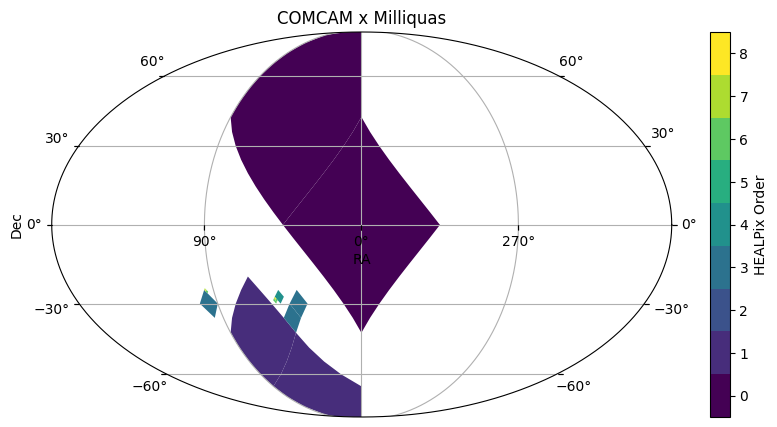

In [9]:
comcam_x_milliquas.plot_pixels(plot_title="COMCAM x Milliquas")

In [10]:
comcam_x_milliquas_computed = comcam_x_milliquas.compute()

In [11]:
client.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:16769'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:12703'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:22335'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:24987'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:22335' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:12703' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:24987' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:16769' closed.


In [17]:
comcam_x_milliquas_computed

# Note: that we use the `tempfile` module to create and then cleanup a temporary directory.
# You can of course remove this and use your own directory and real files on your system.
comcam_x_milliquas_computed.to_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The output file path


In [18]:
len(comcam_x_milliquas_computed)

177

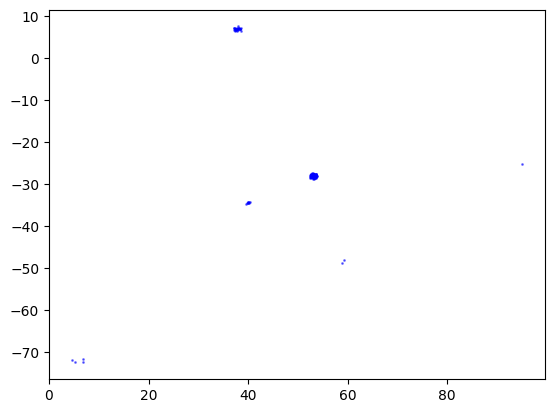

In [19]:
plt.scatter(comcam_x_milliquas_computed[['ra_COM']], 
            comcam_x_milliquas_computed[['dec_COM']],
            s=1,
            c='blue',
            alpha=0.5,
            label='COMCAM',
            marker='o'
           )

In [20]:
comcam_x_milliquas_computed["diaObjectForcedSource_COM"]

_healpix_29
9583286184991586       [{parentObjectId: 0, coord_ra: 37.78485, coord...
9589207111731798       [{parentObjectId: 0, coord_ra: 38.493226, coor...
                                             ...                        
2531133149718993894    [{parentObjectId: 0, coord_ra: 39.903773, coor...
2531133272813443525    [{parentObjectId: 0, coord_ra: 39.954222, coor...
Name: diaObjectForcedSource_COM, Length: 177, dtype: nested<parentObjectId: [int64], coord_ra: [double], coord_dec: [double], visit: [int64], detector: [int16], band: [string], psfFlux: [float], psfFluxErr: [float], psfFlux_flag: [bool], psfDiffFlux: [float], psfDiffFluxErr: [float], psfDiffFlux_flag: [bool], diff_PixelFlags_nodataCenter: [bool], pixelFlags_bad: [bool], pixelFlags_cr: [bool], pixelFlags_crCenter: [bool], pixelFlags_edge: [bool], pixelFlags_interpolated: [bool], pixelFlags_interpolatedCenter: [bool], pixelFlags_nodata: [bool], pixelFlags_saturated: [bool], pixelFlags_saturatedCenter: [bool], pixelFla

In [21]:
bands = ["u", "g", "r", "i", "z", "y"]

def count_bands(entry):
    result = {}
    for band in bands:
        try:
            result[band] = (entry['band'] == band).sum()
        except Exception:
            result[band] = 0
    return result


# Apply to each row
band_counts = comcam_x_milliquas_computed["diaObjectForcedSource_COM"].apply(count_bands)
# Turn into a proper DataFrame
band_counts_df = pd.DataFrame(band_counts.tolist()).fillna(0).astype(int)

# Add to original
for band in bands:
    comcam_x_milliquas_computed[f"n_{band}"] = band_counts_df[band].values

In [22]:
comcam_x_milliquas_computed

diaObjectId_COM     ra_COM    dec_COM  \
_healpix_29                                                      
9583286184991586     4601816802056470555   37.78485   6.401707   
9589207111731798     4602278596940136493  38.493226   6.427911   
...                                  ...        ...        ...   
2531133149718993894  1766616118673277889  39.903773 -34.358387   
2531133272813443525  1766616118673278246  39.954222 -34.333328   

                     nDiaSources_COM  radecMjdTai_COM  tract_COM  \
_healpix_29                                                        
9583286184991586                   9     60643.083293      10463   
9589207111731798                   2     60638.131253      10464   
...                              ...              ...        ...   
2531133149718993894                6     60650.179955       4016   
2531133272813443525                1     60639.270055       4016   

                                                         diaSource_COM  \
_healpix_29                                                              
9583286184991586     [{visit: 2024112300214, detector: 8, band: 'r'...   
9589207111731798     [{visit: 2024112300221, detector: 5, band: 'r'...   
...                                                                ...   
2531133149718993894  [{visit: 2024112400239, detector: 4, band: 'r'...   
2531133272813443525  [{visit: 2024112400274, detector: 4, band: 'i'...   

                                             diaObjectForcedSource_COM  \
_healpix_29                                                              
9583286184991586     [{parentObjectId: 0, coord_ra: 37.78485, coord...   
9589207111731798     [{parentObjectId: 0, coord_ra: 38.493226, coor...   
...                                                                ...   
2531133149718993894  [{parentObjectId: 0, coord_ra: 39.903773, coor...   
2531133272813443525  [{parentObjectId: 0, coord_ra: 39.954222, coor...   

                        RA_MIL    DEC_MIL  ...               RNAME_MIL  \
_healpix_29                                ...                           
9583286184991586     37.784846   6.401708  ...                           
9589207111731798     38.493228    6.42792  ...  VLAJ023358.35+062540.6   
...                        ...        ...  ...                     ...   
2531133149718993894  39.903809 -34.358342  ...                           
2531133272813443525  39.954219 -34.333329  ...                           

                                  LOBE1_MIL               LOBE2_MIL  \
_healpix_29                                                           
9583286184991586                                                      
9589207111731798     FIRST J023358.3+062540  RACS J023358.4+062541    
...                                     ...                     ...   
2531133149718993894                                                   
2531133272813443525                                                   

                     _dist_arcsec n_u n_g n_r  n_i n_z n_y  
_healpix_29                                                 
9583286184991586         0.013628   0  12  10   13   4   0  
9589207111731798         0.033737   0   3   4    6   4   0  
...                           ...  ..  ..  ..  ...  ..  ..  
2531133149718993894      0.191274   0   4  24   10   0   0  
2531133272813443525      0.011135   0   4  23   11   0   0  

[177 rows x 31 columns]

(array([69., 14.,  8., 13.,  6., 14., 11., 12.,  9., 21.]),
 array([  0. ,  15.4,  30.8,  46.2,  61.6,  77. ,  92.4, 107.8, 123.2,
        138.6, 154. ]),
 <BarContainer object of 10 artists>)

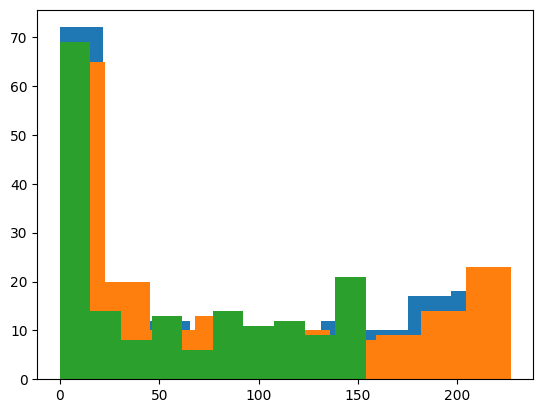

In [23]:
plt.hist(comcam_x_milliquas_computed['n_g'])
plt.hist(comcam_x_milliquas_computed['n_r'])
plt.hist(comcam_x_milliquas_computed['n_i'])

### Are the AGNs found in ComCam roughly the same brightness (in mag) as what is reported in MilliQuas?

In [24]:
# Absolute and relative differences in the magnitudes of the first partition

# Using the mean of the "scienceMag" from the COMCAM sources
# and the "RMAG_MIL" from the Milliquas objects

rows_to_print = 29
for i in range(len(comcam_x_milliquas_computed)):
    single_lc = comcam_x_milliquas_computed.iloc[i]['diaObjectForcedSource_COM'] 
    single_lc_r = single_lc[single_lc['band'] == 'r']
    mean_mag_COM = np.median(single_lc_r["psfMag"])
    mag_MIL = comcam_x_milliquas_computed.iloc[i]["RMAG_MIL"]
    abs_diff = np.abs(mean_mag_COM - mag_MIL)
    rel_diff = abs_diff / mag_MIL

    if rows_to_print:
        print(f"i:{i}  Abs: {abs_diff:>5.2}, Rel: {rel_diff:.2}")
        rows_to_print -= 1

i:0  Abs:  0.21, Rel: 0.011
i:1  Abs:  0.37, Rel: 0.02
i:2  Abs:  0.37, Rel: 0.02
i:3  Abs:  0.22, Rel: 0.011
i:4  Abs:   0.5, Rel: 0.026
i:5  Abs:   2.2, Rel: 0.14
i:6  Abs:  0.26, Rel: 0.013
i:7  Abs:  0.17, Rel: 0.0092
i:8  Abs:  0.12, Rel: 0.0066
i:9  Abs: 0.076, Rel: 0.0039
i:10  Abs:  0.43, Rel: 0.024
i:11  Abs:  0.26, Rel: 0.014
i:12  Abs:  0.18, Rel: 0.0095
i:13  Abs:  0.44, Rel: 0.024
i:14  Abs:  0.36, Rel: 0.019
i:15  Abs:  0.68, Rel: 0.034
i:16  Abs:  0.88, Rel: 0.046
i:17  Abs:  0.24, Rel: 0.012
i:18  Abs:  0.07, Rel: 0.0038
i:19  Abs:  0.26, Rel: 0.013
i:20  Abs:  0.16, Rel: 0.0084
i:21  Abs:  0.24, Rel: 0.012
i:22  Abs:  0.83, Rel: 0.042
i:23  Abs:  0.17, Rel: 0.0089
i:24  Abs:  0.18, Rel: 0.0093
i:25  Abs:  0.68, Rel: 0.038
i:26  Abs:  0.16, Rel: 0.0079
i:27  Abs:   0.2, Rel: 0.01
i:28  Abs:  0.33, Rel: 0.019


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


## Plot lightcurves

"Depending on the numer of the objects we can discuss how to do this best."

In [ ]:
# There are 87 rows in the first partition

# This is a similar order of magnitude as "ZTF and PS1 for SNAD catalog" (link), so can reference if needed
# https://docs.lsdb.io/en/stable/tutorials/pre_executed/zubercal-ps1-snad.html

### Mag LCs

Referencing plots in: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

In [25]:
comcam_AGN_many_r = comcam_x_milliquas_computed[comcam_x_milliquas_computed['n_r']>210]

In [ ]:
{'u': '#0c71ff',
 'g': '#49be61',
 'r': '#c61c00',
 'i': '#ffc200',
 'z': '#f341a2',
 'y': '#5d0000'}

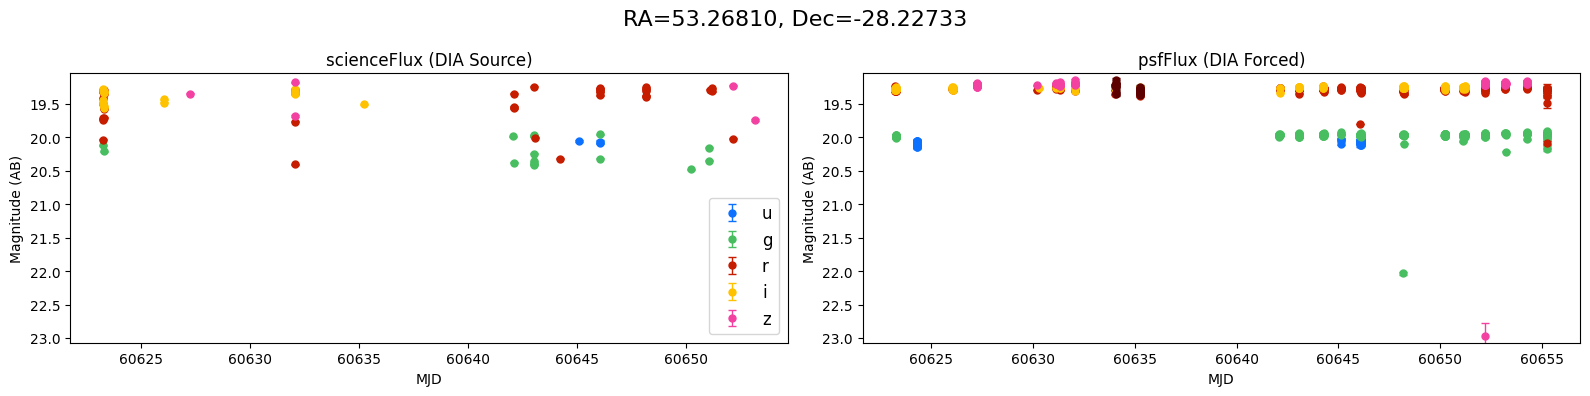

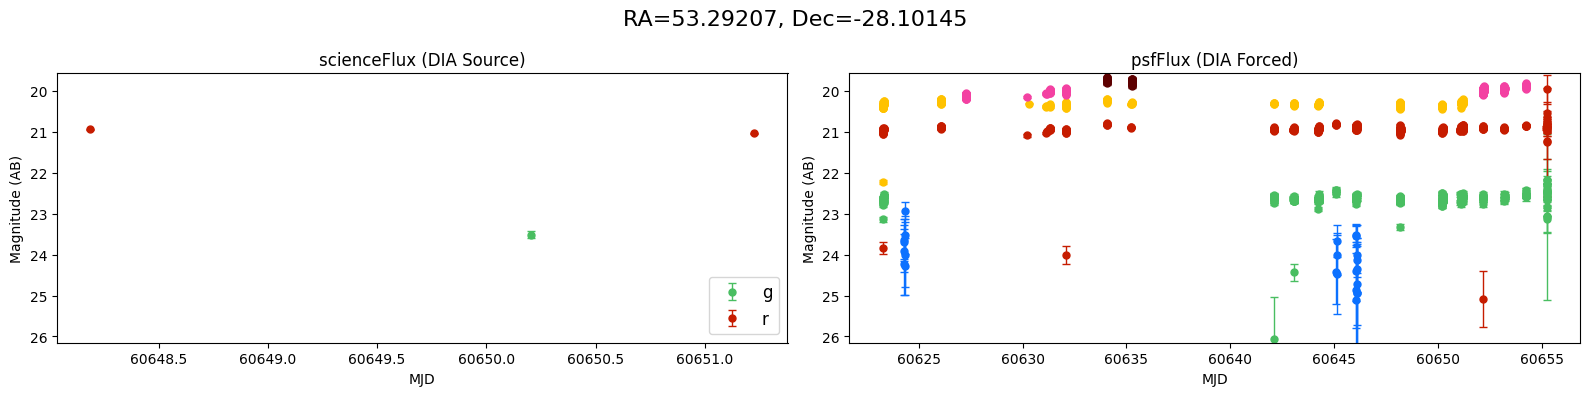

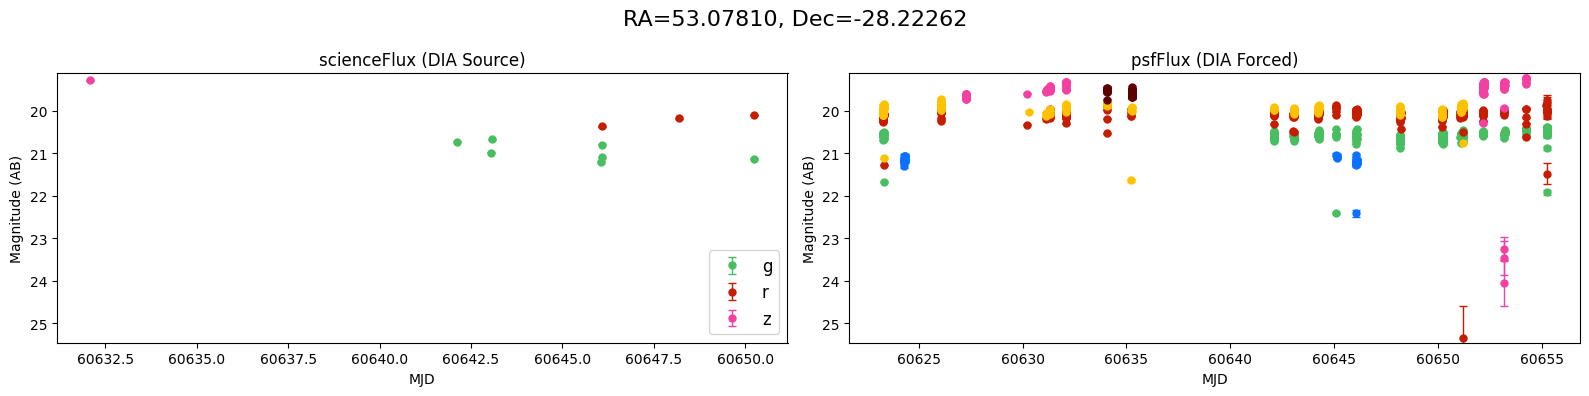

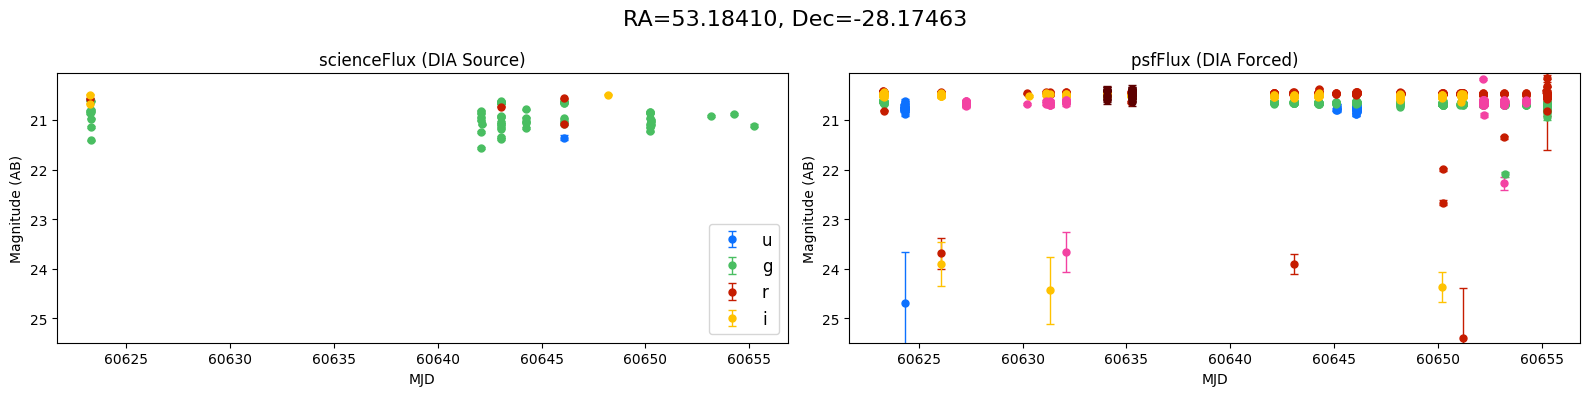

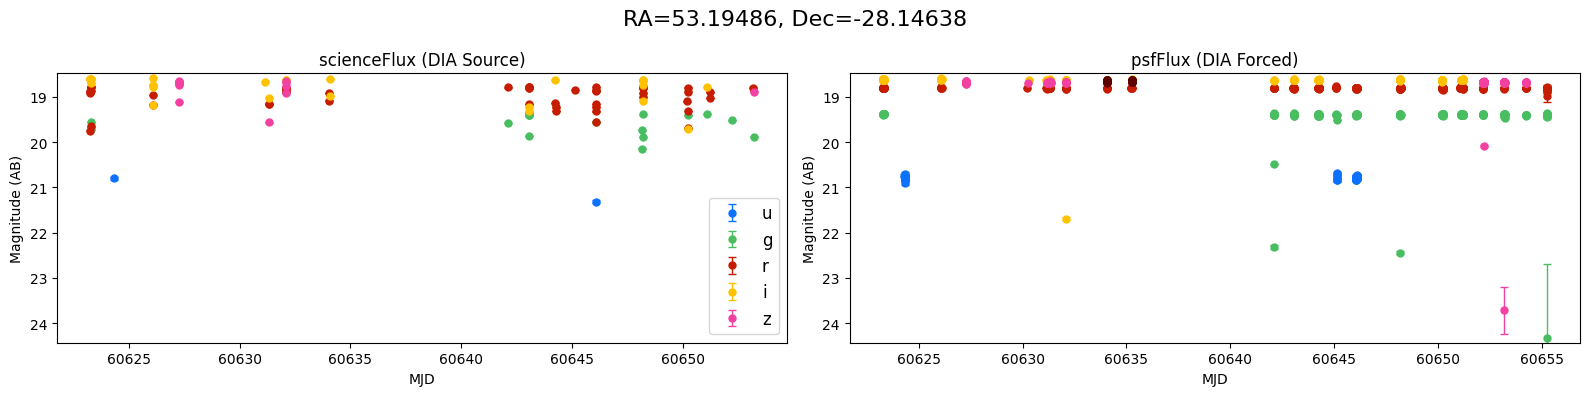

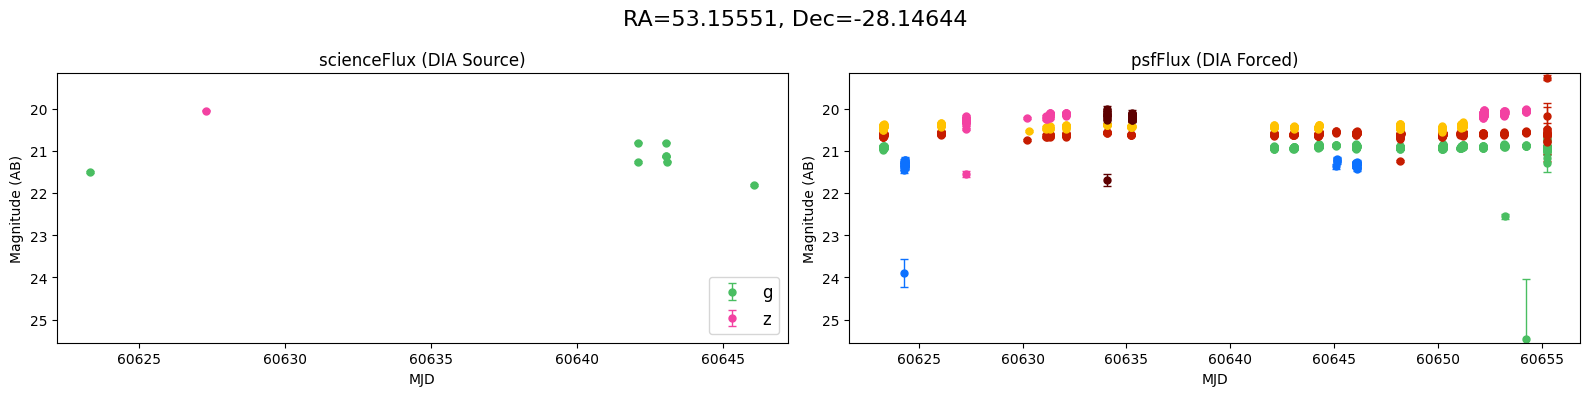

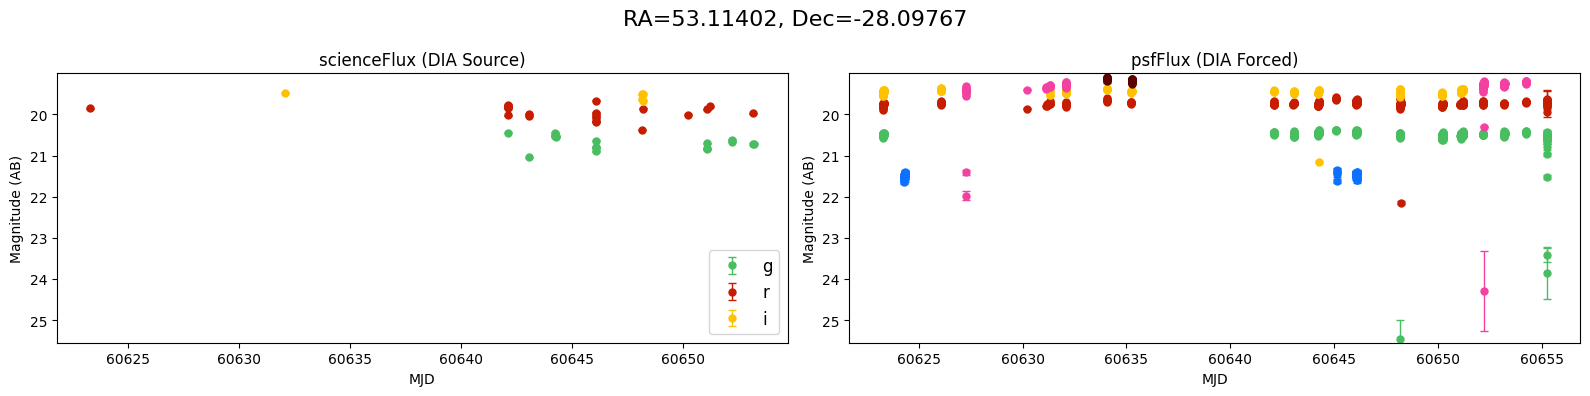

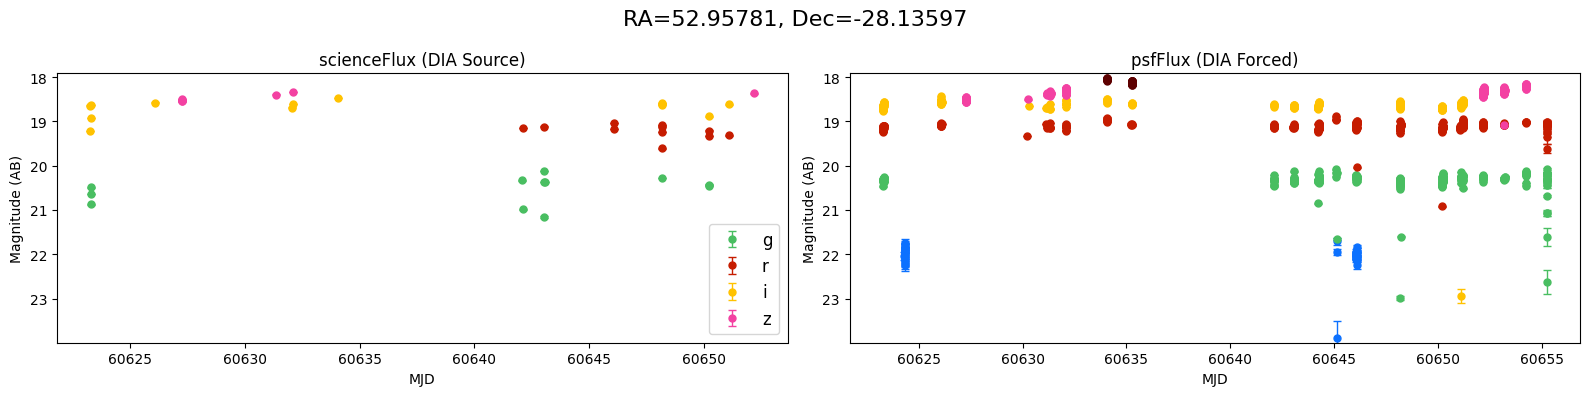

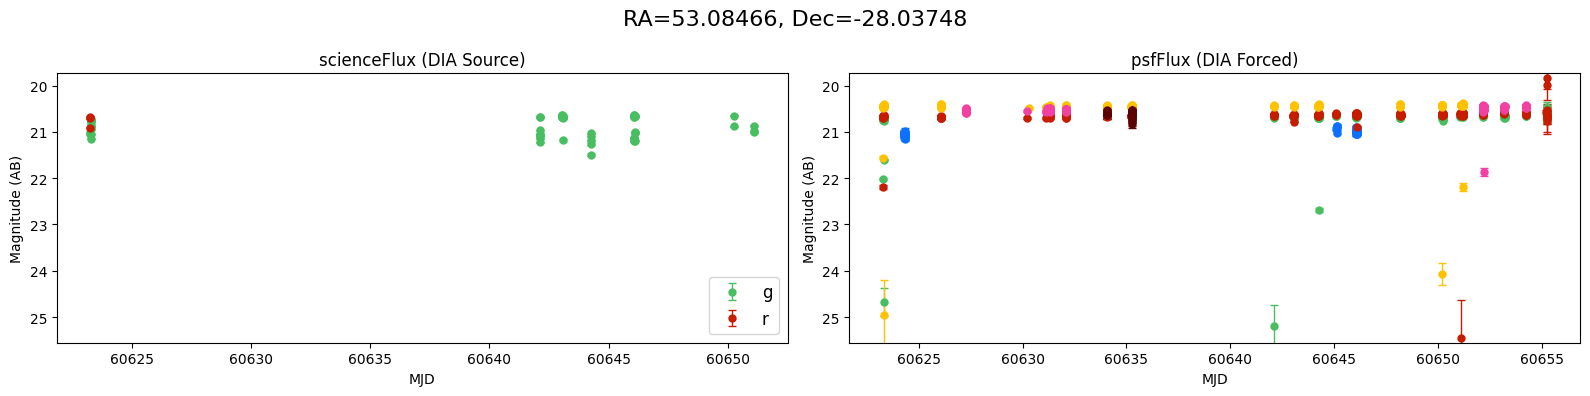

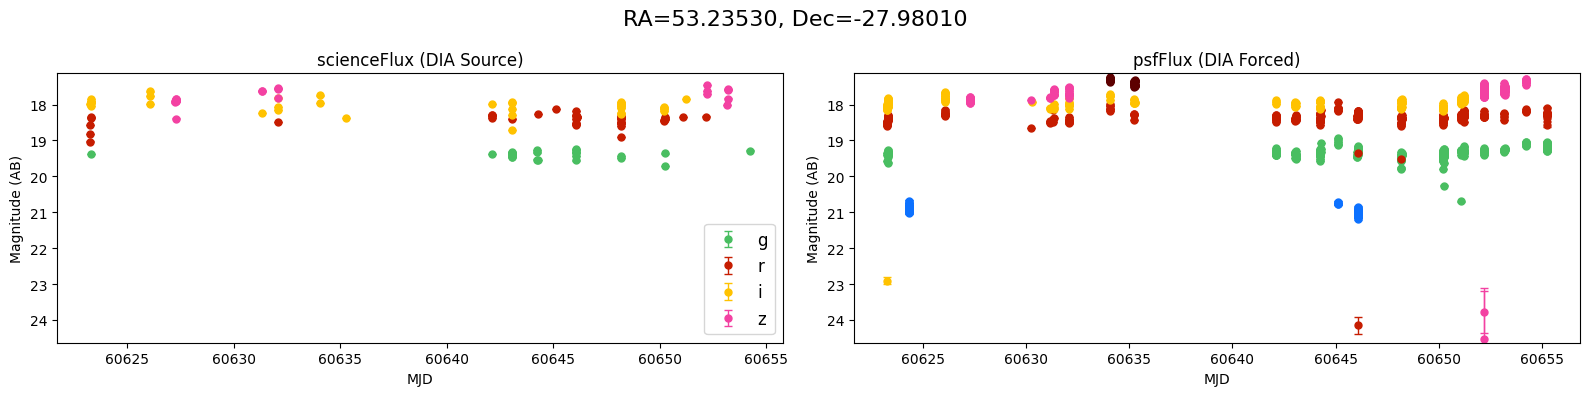

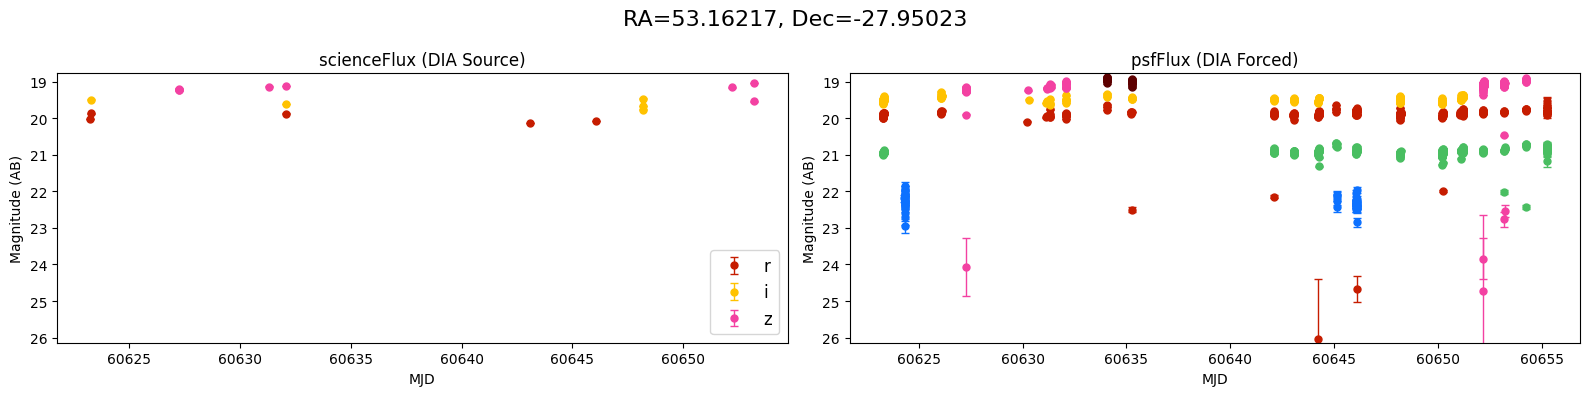

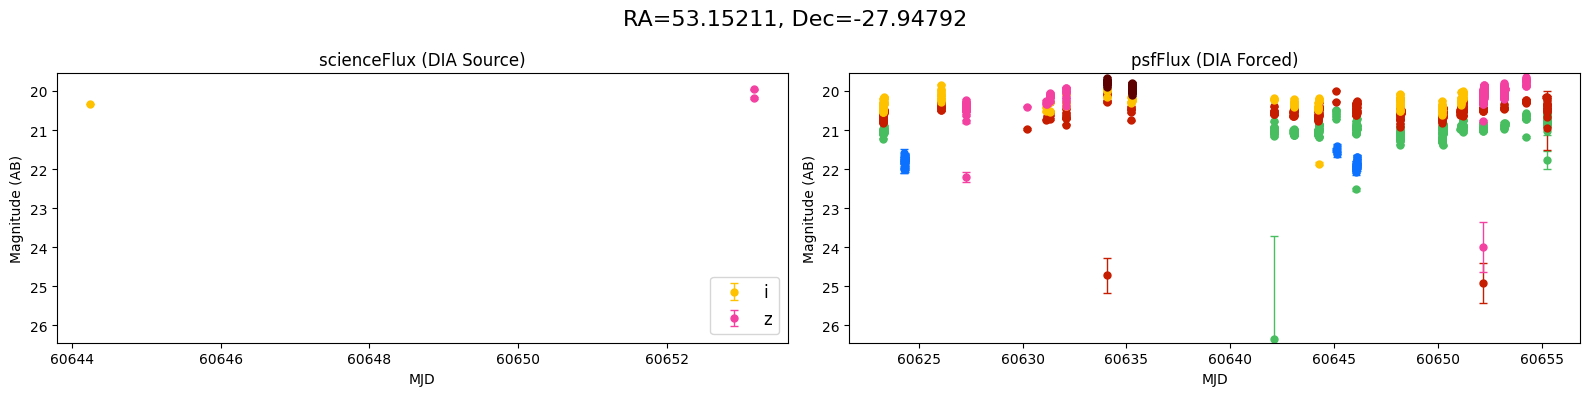

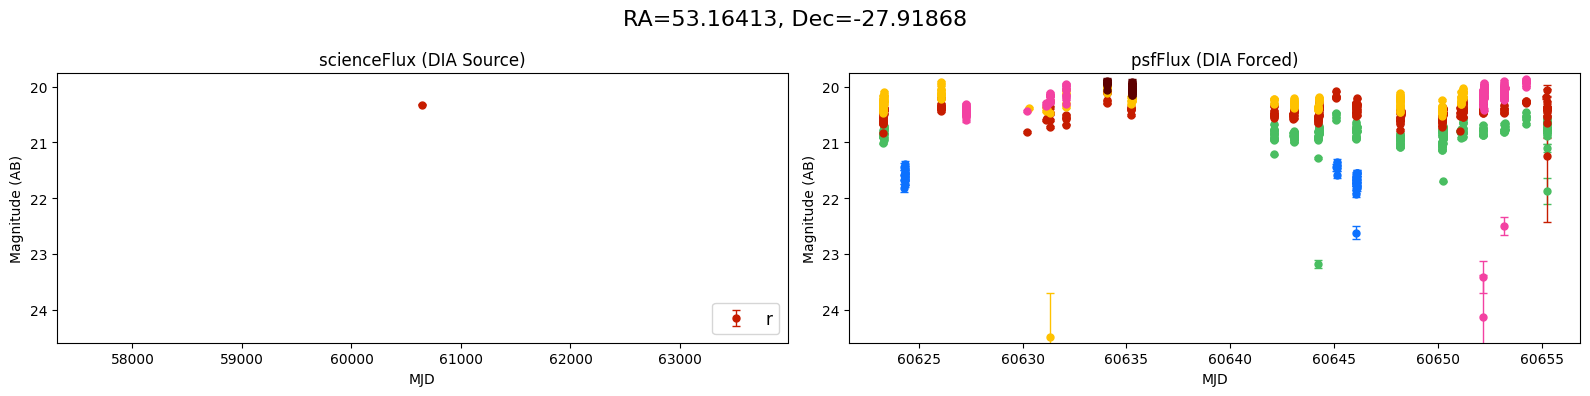

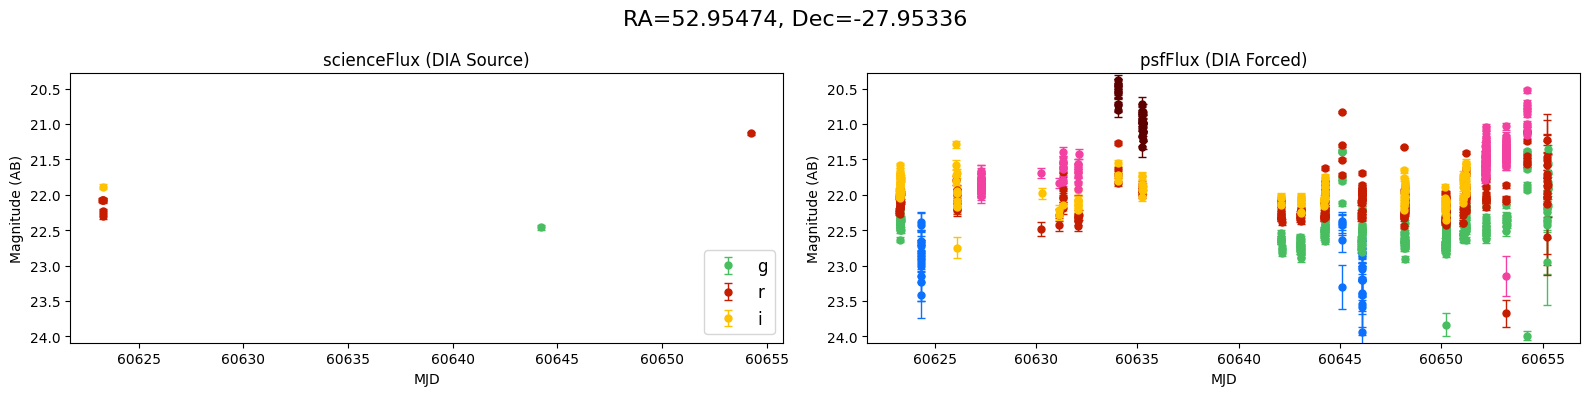

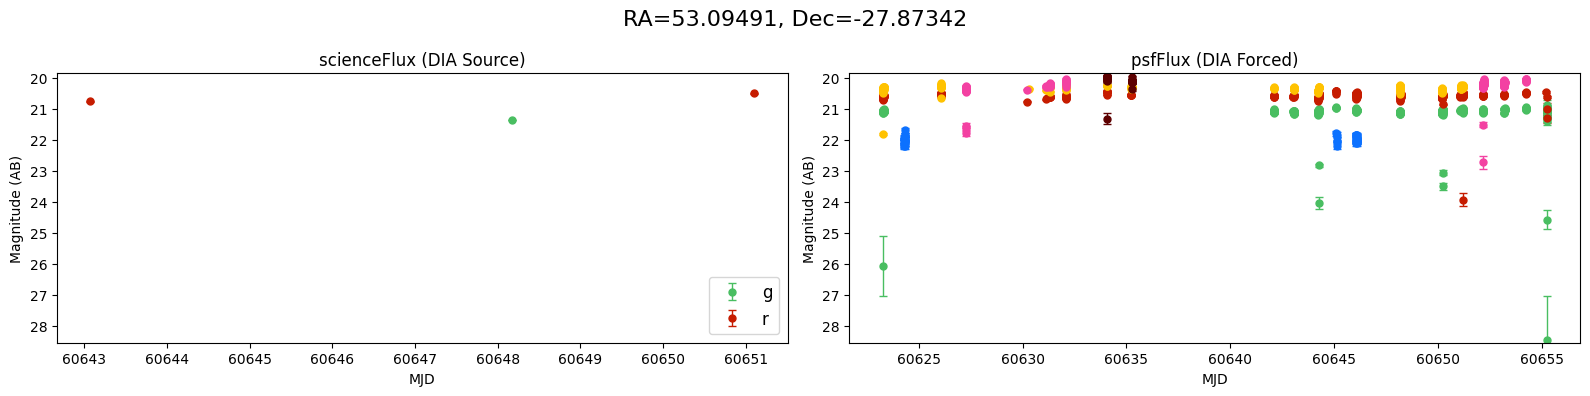

In [31]:
COLORS = {'u': '#0c71ff',
 'g': '#49be61',
 'r': '#c61c00',
 'i': '#ffc200',
 'z': '#f341a2',
 'y': '#5d0000'}

def create_mag_errors(flux, flux_err):
    # Make sure everything is valid and flux ± err stays positive
    upper = flux + flux_err
    lower = flux - flux_err
    mask = (
        flux.notna()
        & flux_err.notna()
        & (flux > 0)
        & (upper > 0)
        & (lower > 0)
    )

    # Initialize with NaNs
    mag = np.full_like(flux, np.nan, dtype=float)
    mag_err = np.full_like(flux, np.nan, dtype=float)

    # Apply the AB mag conversion only to valid values
    valid_flux = flux[mask]
    valid_err = flux_err[mask]

    mag[mask] = u.nJy.to(u.ABmag, valid_flux)
    upper_mag = u.nJy.to(u.ABmag, valid_flux + valid_err)
    lower_mag = u.nJy.to(u.ABmag, valid_flux - valid_err)
    mag_err[mask] = -(upper_mag - lower_mag) / 2

    return pd.Series(mag, index=flux.index), pd.Series(mag_err, index=flux.index)

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    mag_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, mag_err = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            mag_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_vals.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)
    return mag_vals

def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        ymin, ymax = np.nanmin(all_mags[0]), np.nanmax(all_mags[0])
        for i in range(2):
            ax[0, i].set_ylim(ymax + 0.1, ymin - 0.1)

def plot_mag_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_mags = [[], []]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_mags[0].extend(
            plot_mag_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_mags

# Now plot
for i in range(len(comcam_AGN_many_r)):
    row = comcam_AGN_many_r.iloc[i]
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))  # Just one row now
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_mags = plot_mag_lightcurves(np.expand_dims(ax, 0), row)  # Make ax 2D for consistency
    scale_mag_y_axis(np.expand_dims(ax, 0), all_mags)
    plt.tight_layout()
    plt.show()

In [29]:
row.diaObjectForcedSource_COM

,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceOnDiaObjectId,psfMag,psfMagErr,midpointMjdTai
0,0,53.09491,-27.873418,2024110800245,1,i,24837.423828,241.975174,False,636.792664,...,False,False,False,False,5063,24,190875481652860782,20.412233,0.010578,60623.258521
1,0,53.09491,-27.873418,2024110800246,1,r,20071.171875,179.688263,False,112.363625,...,False,False,False,False,5063,24,190875482726602673,20.643568,0.009720,60623.259329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,53.09491,-27.873418,2024121000433,2,g,13589.772461,1077.794067,False,404.807098,...,False,False,False,False,5063,24,192001583427355632,21.066969,0.086290,60655.249581
725,0,53.09491,-27.873418,2024121000434,2,g,13576.779297,559.793579,False,-327.085205,...,False,False,False,False,5063,24,192001584501097335,21.068008,0.044792,60655.249976


### Flux LCs

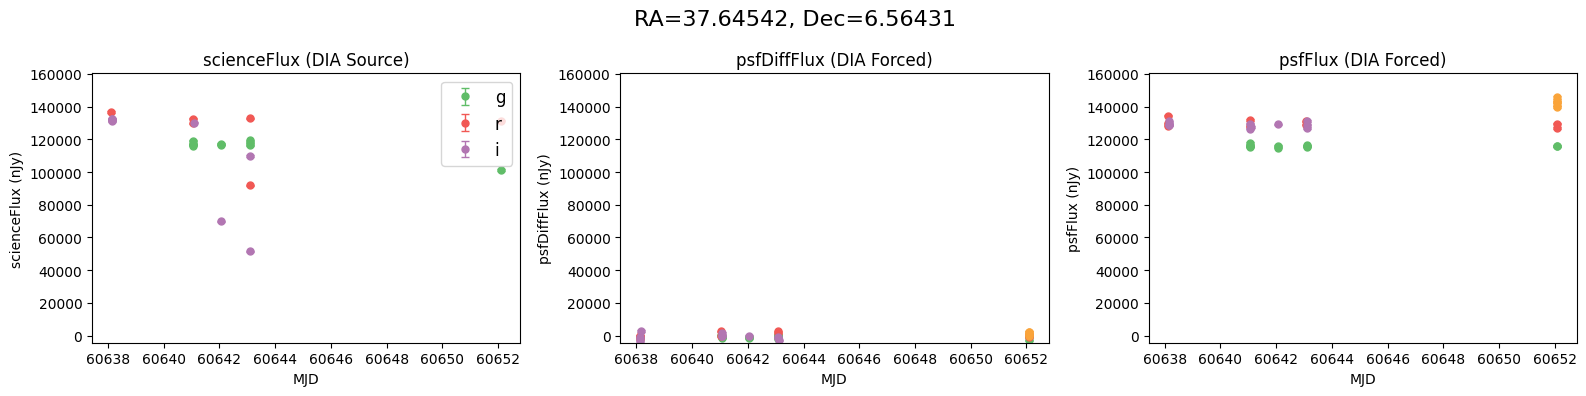

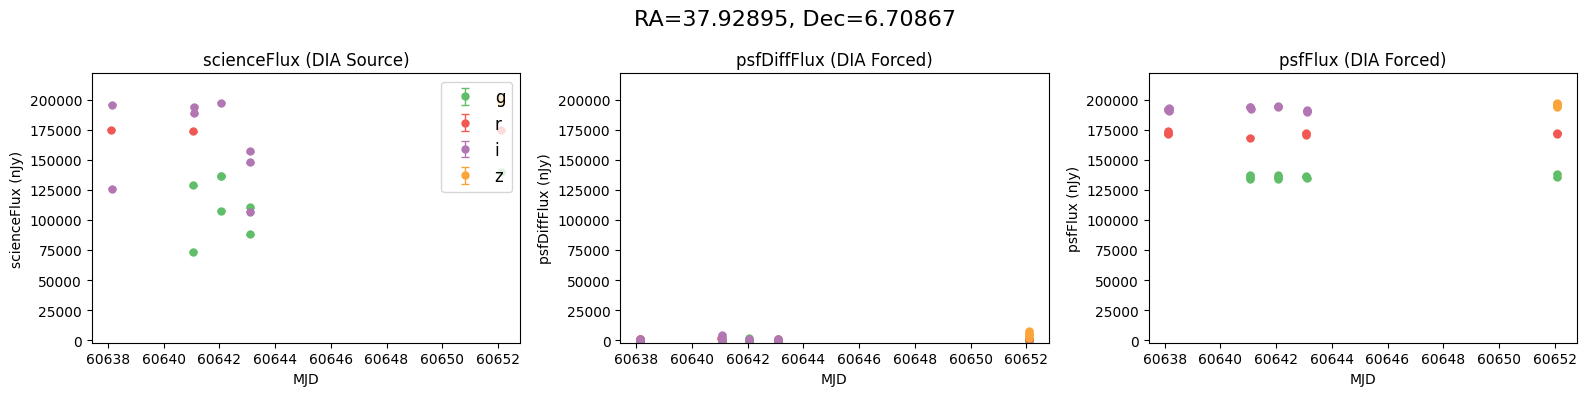

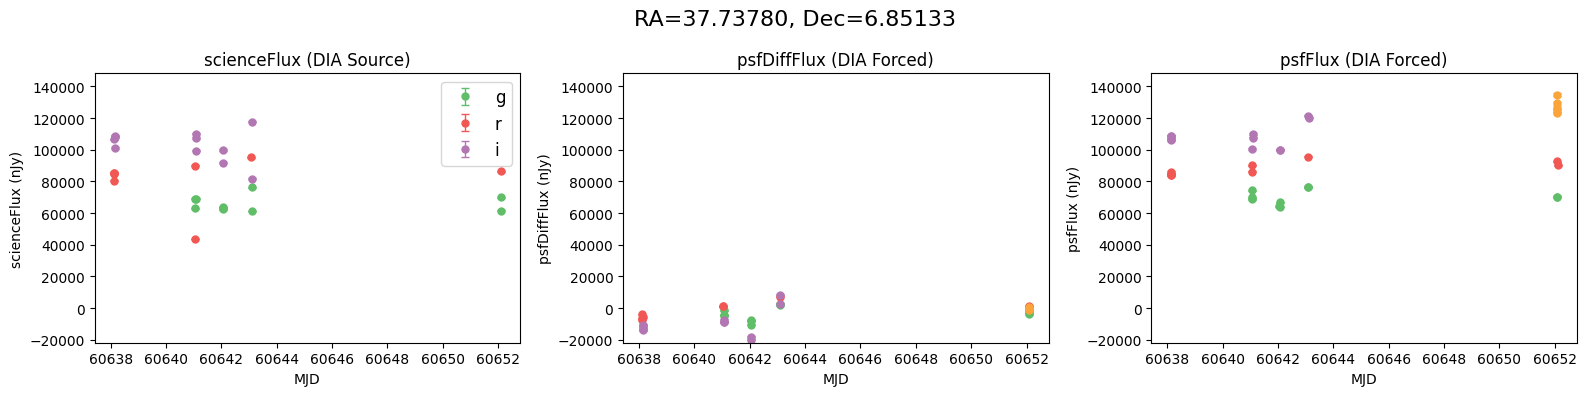

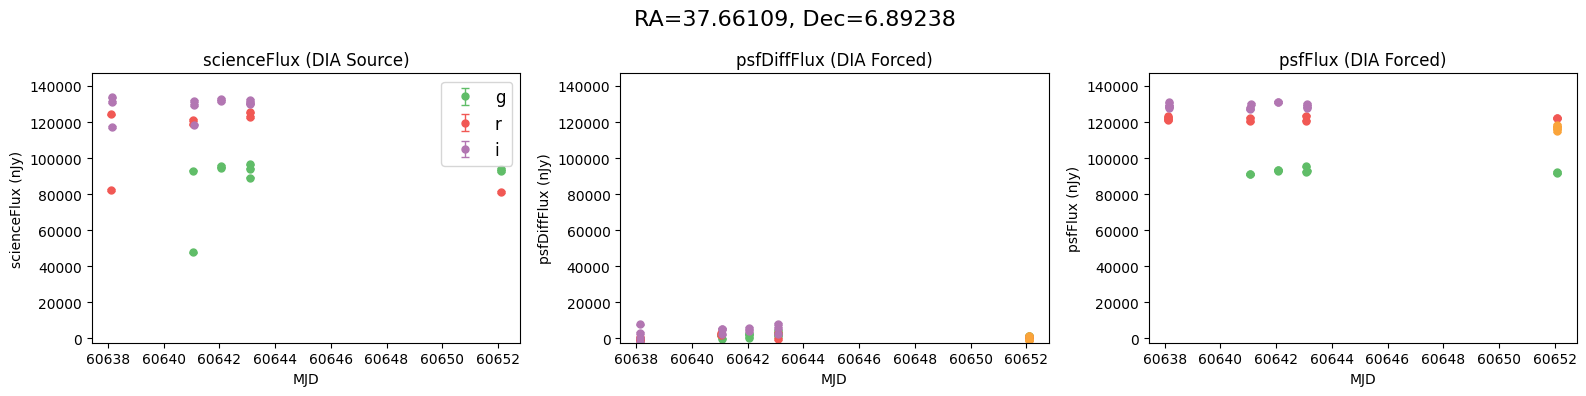

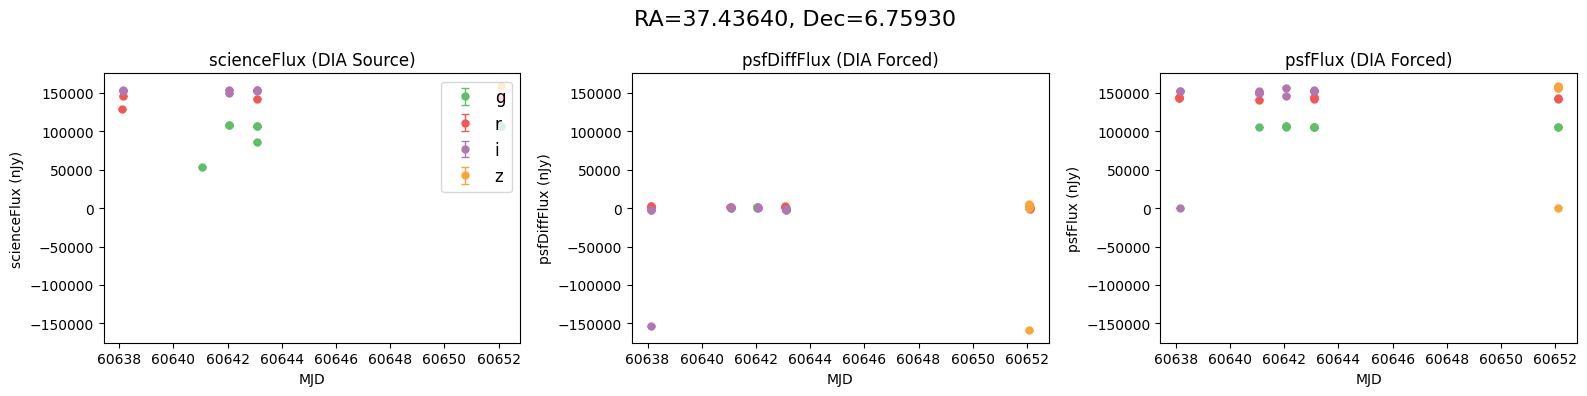

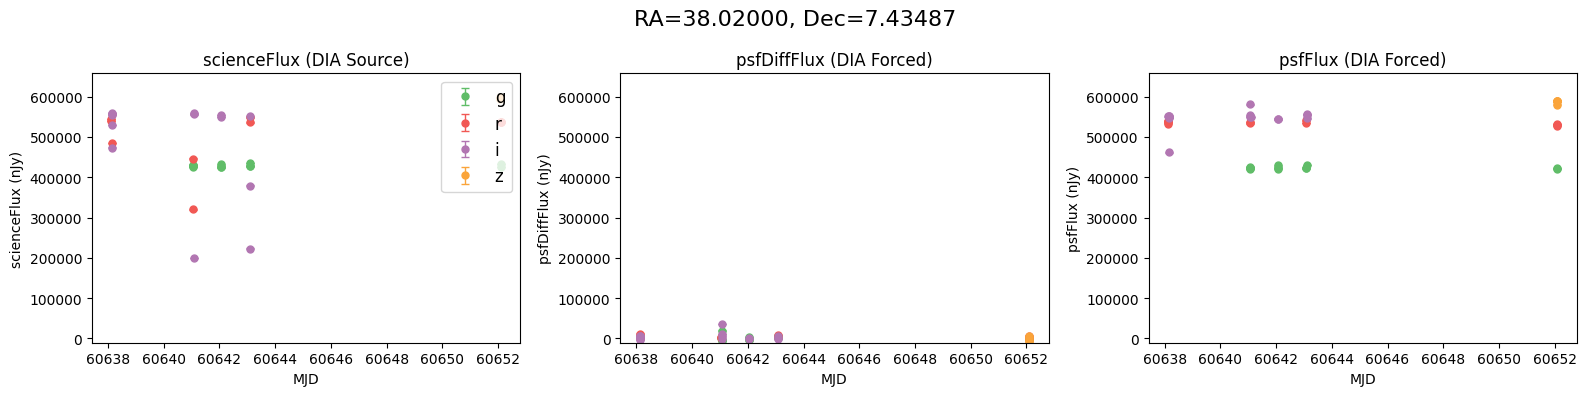

In [ ]:
def plot_flux_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    flux_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        ax.errorbar(
            band_lc[x_name],
            band_lc[flux_col],
            band_lc[flux_err_col],
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        flux_vals.extend(band_lc[flux_col].dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{flux_col} (nJy)")
    if show_legend:
        ax.legend(loc="upper right", fontsize=12)
    return flux_vals

def scale_flux_y_axis(ax, all_flux):
    if all_flux[0]:
        ymin, ymax = np.nanmin(all_flux[0]), np.nanmax(all_flux[0])
        for i in range(3):
            ax[0, i].set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))

def plot_flux_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfDiffFlux", "DIA Forced", row.diaObjectForcedSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_flux = [[]]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_flux[0].extend(
            plot_flux_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_flux

for i in good_indices:
    row = ndf.loc[i]
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_flux = plot_flux_lightcurves(np.expand_dims(ax, 0), row)
    scale_flux_y_axis(np.expand_dims(ax, 0), all_flux)
    plt.tight_layout()
    plt.show()


In [ ]:
# Flux error bars--there, just small

row = ndf.loc[good_indices[0]]
row.diaObjectForcedSource_COM[["psfFlux", "psfFluxErr"]].describe()

,psfFlux,psfFluxErr
count,36.000000,36.000000
mean,127081.179688,456.536346
std,8908.214844,137.870178
min,114712.789062,335.543762
25%,116358.169922,372.301979
50%,128869.582031,407.274002
75%,130889.429688,469.743111
max,145736.031250,859.355530


## Plot structure function

Referencing: https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/variable_stars/var_stars_sf.ipynb

In [ ]:
from numba import njit

@njit
def calcSF(taumin, taumax, tclip, fclip, nstep):
    dtau = (np.log10(taumax) - np.log10(taumin)) / nstep

    tau1 = np.zeros(nstep)
    tau2 = np.zeros(nstep)
    N = np.zeros(nstep)
    SF = np.zeros(nstep)

    for k in range(nstep):
        tau1[k] = 10**(np.log10(taumin) + k*dtau)
        tau2[k] = 10**(np.log10(tau1[k]) + dtau)
        for i in range(tclip.size):
            dist = tclip[i:] - tclip[i]
            sel = (dist >= tau1[k]) & (dist < tau2[k])
            N[k] += tclip[i:][sel].size
            if tclip[i:][sel].size > 0:
                SF[k] += np.sum((fclip[i:][sel] - fclip[i])**2)
        SF[k] = np.sqrt(SF[k] / N[k]) if N[k] > 0 else np.nan

    return tau1, tau2, SF, N


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def SF_analysis(df, nstep=50, Nmin=2):
    objects = df['Object_ID'].unique()

    for obj in objects:
        obj_data_all = df[df['Object_ID'] == obj]

        fig_sf, ax_sf = plt.subplots(figsize=(7, 3))
        ax_sf.set_title(f"Structure Function: {obj}")

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']

            # Iterative 5σ clipping
            count_old = len(mag) + 1
            count = len(mag)
            excluded = [[], []]

            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                outliers = np.abs(mag - mag_mean) >= 5 * mag_std
                excluded[0] += filt_data['Epoch'][outliers].to_list()
                excluded[1] += mag[outliers].to_list()
                filt_data = filt_data[~outliers]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            # Convert mag → normalized flux
            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()

            # SF time limits
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)

            ax_sf.loglog(tau1[N > Nmin], SF[N > Nmin], label=filt, marker="o", linestyle="")

        ax_sf.set_xlabel("Time lag (days)")
        ax_sf.set_ylabel("Structure Function")
        ax_sf.grid(True)
        ax_sf.legend()
        plt.show()


In [ ]:
def make_long_df(catalog):
    rows = []
    for _, row in catalog.iterrows():
        obj_id = row.diaObjectId_COM
        for table in ['diaSource_COM', 'diaObjectForcedSource_COM']:
            lc = row[table]
            if lc.empty:
                continue
            for _, lc_row in lc.iterrows():
                if lc_row['psfFlux'] > 0 and not lc_row['psfFlux_flag']:
                    flux = lc_row['psfFlux']
                    flux_err = lc_row['psfFluxErr']
                    mag = -2.5 * np.log10(flux / 3631e9)  # Convert nJy to AB mag
                    rows.append({
                        'Object_ID': obj_id,
                        'Filter': lc_row['band'],
                        'Epoch': lc_row['midpointMjdTai'],
                        'psfFlux': flux,
                        'psfFluxErr': flux_err,
                        'Mag': mag,
                    })
    return pd.DataFrame(rows)

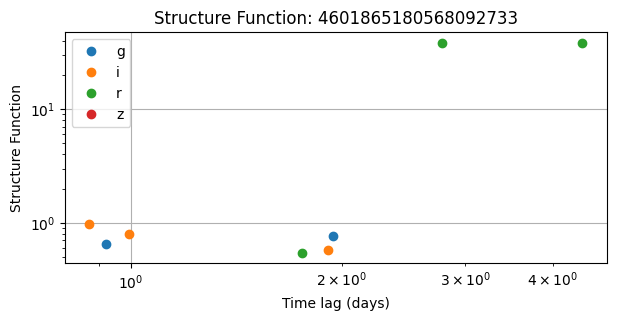

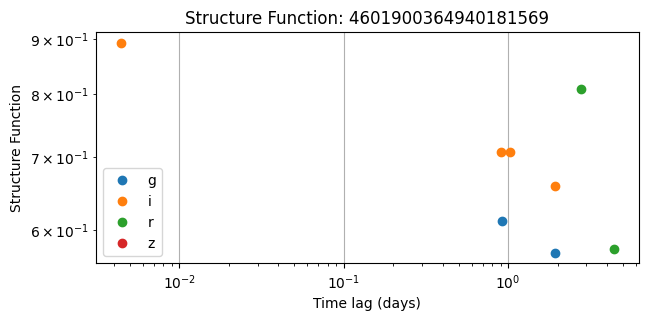

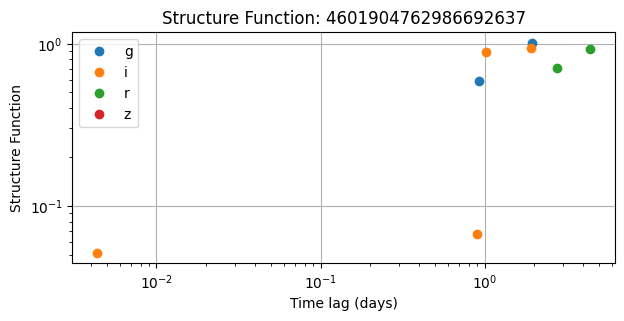

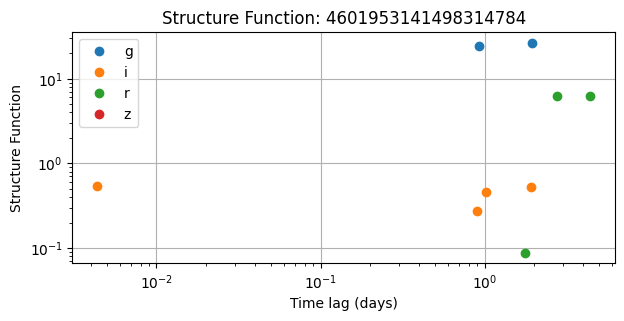

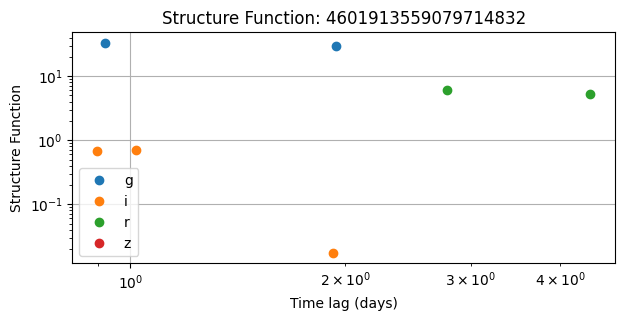

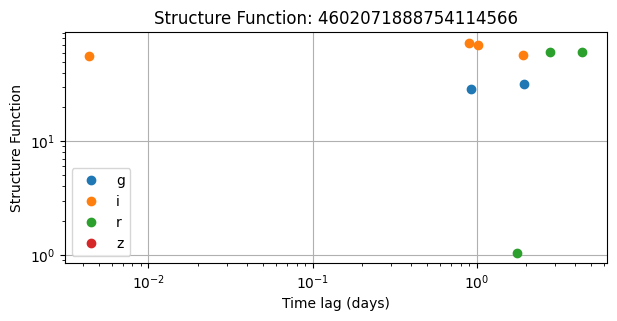

In [ ]:
good_df = ndf.loc[good_indices]
lc_long_df = make_long_df(good_df)
SF_analysis(lc_long_df)

### All on the same plot

In [ ]:
def SF_compare_plot(df, nstep=50, Nmin=2, legend=True):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_title("Structure Functions (All Objects)")
    
    for obj in df['Object_ID'].unique():
        obj_data_all = df[df['Object_ID'] == obj]

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']
            count_old = len(mag) + 1
            count = len(mag)
            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                filt_data = filt_data[np.abs(mag - mag_mean) < 5 * mag_std]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)
            
            label = f"{obj} ({filt})"
            ax.loglog(tau1[N > Nmin], SF[N > Nmin], label=label, marker="o", linestyle="")

    ax.set_xlabel("Time lag (days)")
    ax.set_ylabel("Structure Function")
    ax.grid(True)
    if legend:
        ax.legend()
    plt.show()


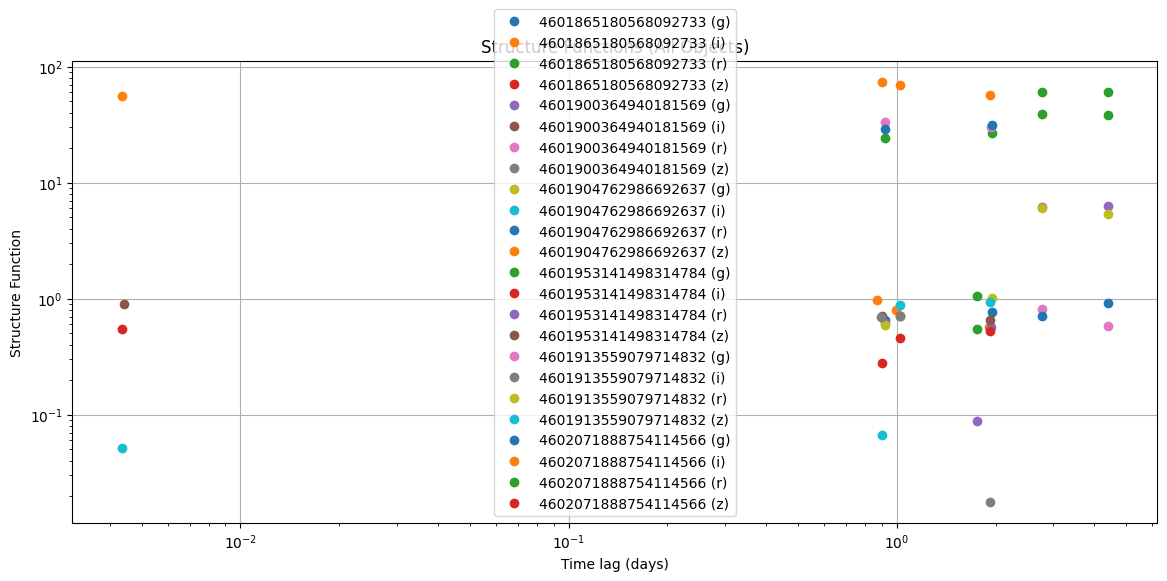

In [ ]:
SF_compare_plot(lc_long_df)

### Adjust cut from >20 to >10 sources

In [ ]:
good_indices_cut_at_10 = []

for i in ndf.index:
    if ndf.loc[i, "nDiaSources_COM"] > 10:
        print(f"Row {i} has {ndf.loc[i, 'nDiaSources_COM']} sources")
        good_indices_cut_at_10.append(i)

print(len(good_indices_cut_at_10))

Row 9612527476569840 has 24 sources
Row 9615793306942506 has 15 sources
Row 9625426085853595 has 22 sources
Row 9629578309504534 has 16 sources
Row 9629995726856429 has 11 sources
Row 9634023935025897 has 29 sources
Row 9634690526094145 has 27 sources
Row 9638975493945711 has 17 sources
Row 9651991629094477 has 12 sources
Row 9652525845238071 has 20 sources
Row 9652568124498163 has 20 sources
Row 9715348208429896 has 21 sources
Row 9717229661831314 has 13 sources
Row 9726271154901693 has 12 sources
Row 9727321198111477 has 19 sources
Row 9734294853593823 has 19 sources
Row 9785092585155222 has 38 sources
17


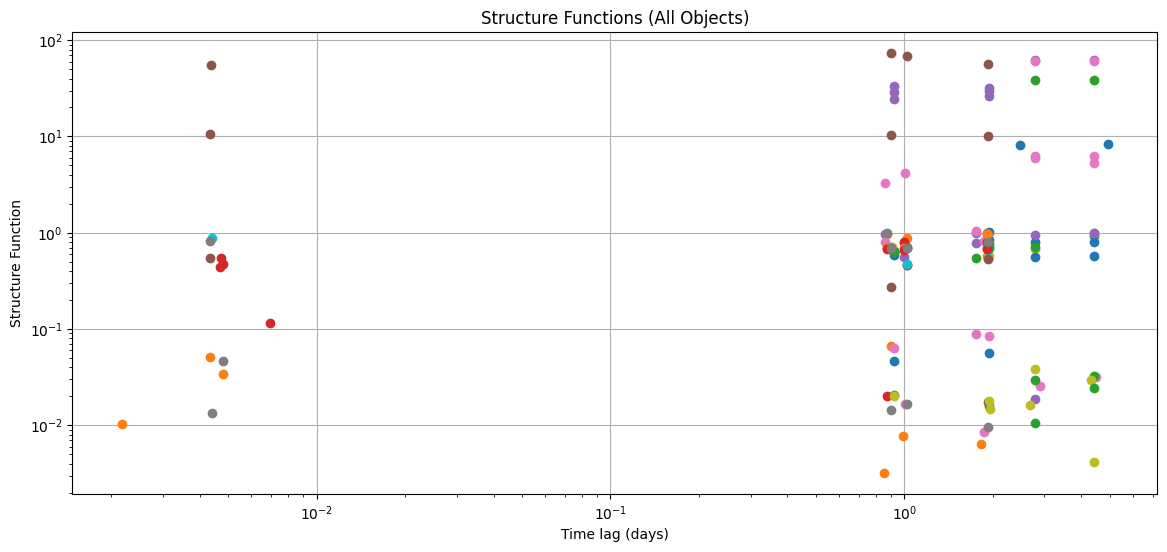

In [ ]:
good_df_cut_at_10 = ndf.loc[good_indices_cut_at_10]
lc_long_df_cut_at_10 = make_long_df(good_df_cut_at_10)
SF_compare_plot(lc_long_df_cut_at_10, legend=False)